<a href="https://colab.research.google.com/github/stevengregori92/DeepUnsupervisedLearning/blob/main/AutoEncoder_Latent_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'jcopdl < 2.0'

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=f77526016ad6e95b7fc3410815853fb51e900c54e534d8dbd76adebfcc0ca15d
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#Import Dataset

In [4]:
!gdown https://drive.google.com/uc?id=1oym_eQFN91auos7El9xJd1KiHW4AmKpD

Downloading...
From: https://drive.google.com/uc?id=1oym_eQFN91auos7El9xJd1KiHW4AmKpD
To: /content/hand.zip
100% 883k/883k [00:00<00:00, 117MB/s]


In [5]:
!unzip /content/hand.zip

Archive:  /content/hand.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/test/
  inflating: data/test/.DS_Store     
   creating: __MACOSX/data/test/
  inflating: __MACOSX/data/test/._.DS_Store  
   creating: data/test/9/
  inflating: data/test/9/176.png     
  inflating: data/test/9/162.png     
  inflating: data/test/9/189.png     
  inflating: data/test/9/200.png     
  inflating: data/test/9/188.png     
  inflating: data/test/9/163.png     
  inflating: data/test/9/177.png     
  inflating: data/test/9/161.png     
  inflating: data/test/9/175.png     
  inflating: data/test/9/174.png     
  inflating: data/test/9/160.png     
  inflating: data/test/9/164.png     
  inflating: data/test/9/170.png     
  inflating: data/test/9/171.png     
  inflating: data/test/9/165.png     
  inflating: data/test/9/173.png     
  inflating: data/test/9/167.png     
  inflatin

#Dataset & Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
bs=64

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('data/train/', transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle = True, num_workers=2)

test_set = datasets. ImageFolder('data/test/', transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle = True)

#Arsitektur & Config

In [8]:
from jcopdl.layers import linear_block

In [9]:
class AutoEncoder(nn.Module):
  def __init__(self, z_size):
    super().__init__()

    self.encode = nn.Sequential(
        linear_block(784, 512, batch_norm=True),
        linear_block(512, 256, batch_norm=True),
        linear_block(256, z_size, activation='sigmoid')
    )

    self.decode = nn.Sequential(
        linear_block(z_size, 256, batch_norm=True),
        linear_block(256, 512, batch_norm=True),
        linear_block(512, 784, activation='sigmoid')
    )

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x

In [10]:
config = set_config({
    'z_size' : 32,
    'batch_size' : bs
})

#Training Preparation -> MCOC

In [11]:
model = AutoEncoder(config.z_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/ae')

#Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = 0
    for feature, _ in tqdm(dataloader, desc=mode.title()):
        feature = feature.view(-1, 784).to(device) # corrected line

        output = model(feature)
        loss = criterion(output, feature)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost/len(dataset)
    return cost

Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3318 | Test_cost  = 0.2591 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1829 | Test_cost  = 0.1745 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1596 | Test_cost  = 0.1537 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1458 | Test_cost  = 0.1427 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        Exception ignored in: self._shutdown_workers()if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/pyth

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1359 | Test_cost  = 0.1354 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1290 | Test_cost  = 0.1283 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1229 | Test_cost  = 0.1246 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1183 | Test_cost  = 0.1205 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionError: can only test a child process
if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1141 | Test_cost  = 0.1175 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

AssertionError: can only test a child processself._shutdown_workers()    

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in: <function _Multi

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1106 | Test_cost  = 0.1156 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1080 | Test_cost  = 0.1126 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():

AssertionError: can only test a child process  File "/usr/lib/p

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1056 | Test_cost  = 0.1108 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    

Train:   0%|          | 0/25 [00:10<?, ?it/s]


if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1026 | Test_cost  = 0.1102 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1007 | Test_cost  = 0.1091 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    : AssertionErrorcan only test a child process
if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0997 | Test_cost  = 0.1074 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0982 | Test_cost  = 0.1062 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0967 | Test_cost  = 0.1054 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700><function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>

Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

self._shutdown_workers()    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    self._sh

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0951 | Test_cost  = 0.1044 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0937 | Test_cost  = 0.1037 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0926 | Test_cost  = 0.1040 | 


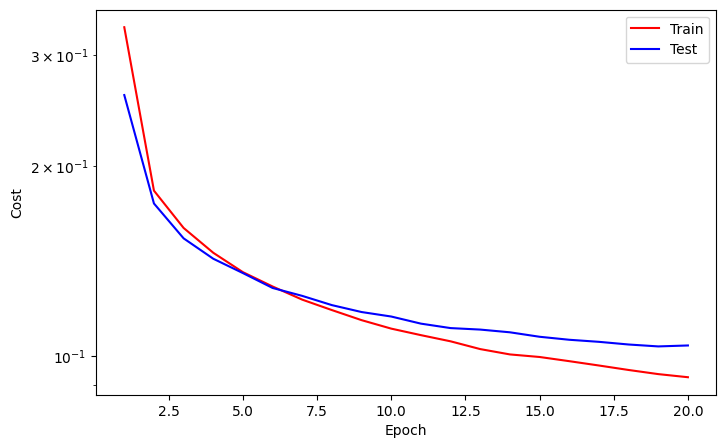

==> EarlyStop patience =  1 | Best test_cost: 0.1037


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0915 | Test_cost  = 0.1029 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0912 | Test_cost  = 0.1019 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0897 | Test_cost  = 0.1014 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0894 | Test_cost  = 0.1016 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1014


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    if w.is_alive():
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():
AssertionError: 
  File "/usr/lib/python3.10/multiprocessing/pro

Train:   0%|          | 0/25 [00:00<?, ?it/s]

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0889 | Test_cost  = 0.1014 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0875 | Test_cost  = 0.1010 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child process
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0867 | Test_cost  = 0.1001 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0859 | Test_cost  = 0.1002 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1001


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
:     self._shutdown_workers()can only test a child process

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0863 | Test_cost  = 0.1007 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1001


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in:         <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>if w.is_alive():if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>  File "/usr/lib/python3.10/multiprocessi

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0856 | Test_cost  = 0.1010 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1001


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0851 | Test_cost  = 0.1001 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1001


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0839 | Test_cost  = 0.0989 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0839 | Test_cost  = 0.1003 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0989


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0835 | Test_cost  = 0.0991 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0989


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/pyt

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0828 | Test_cost  = 0.0991 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0989


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0822 | Test_cost  = 0.0984 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0819 | Test_cost  = 0.0983 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>

Train:   0%|          | 0/25 [00:00<?, ?it/s]


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700><function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0822 | Test_cost  = 0.0985 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0983


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0808 | Test_cost  = 0.0987 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0983


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
AssertionError    : can only test a child processif w.is_alive():

  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0806 | Test_cost  = 0.0987 | 


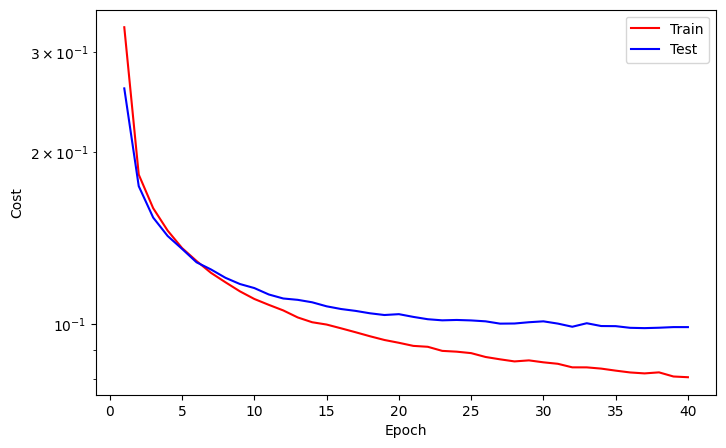

==> EarlyStop patience =  3 | Best test_cost: 0.0983


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0808 | Test_cost  = 0.0991 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0983


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f42a5720700>    
Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

AssertionError    : if w.is_alive():
can only test a child process
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.0806 | Test_cost  = 0.0983 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0983
==> Execute Early Stopping at epoch: 42 | Best test_cost: 0.0983
==> Best model is saved at model/ae


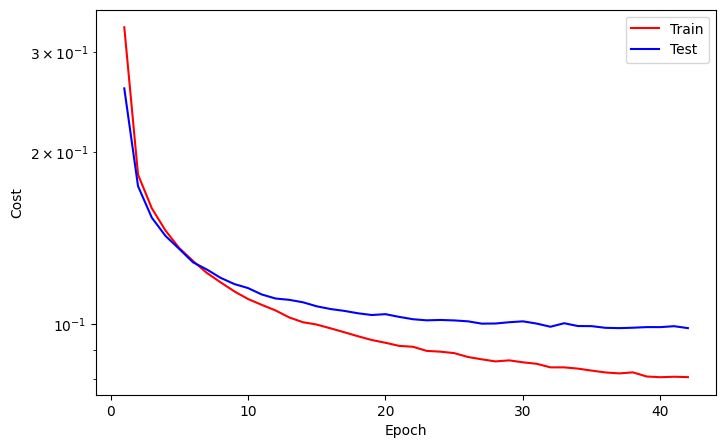

In [13]:
while True:
  train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_cost'):
    callback.plot_cost()
    break

#Evaluate

In [14]:
feature, target = next(iter(testloader))
feature = feature.view(-1, 784).to(device)

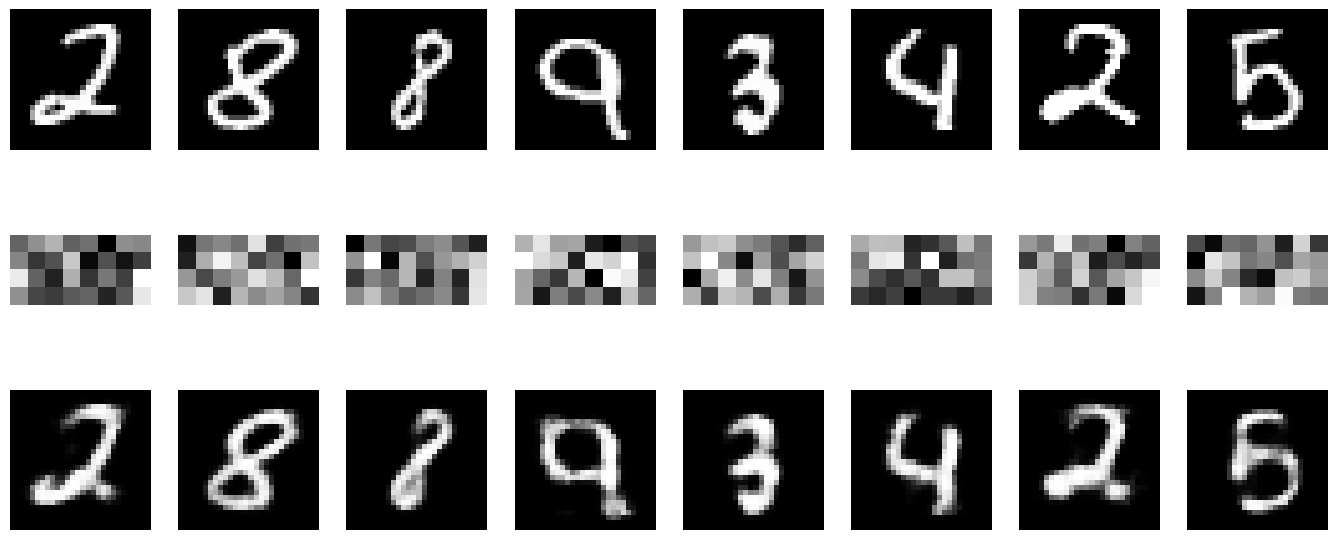

In [15]:
with torch.no_grad():
  model.eval()
  enc = model.encode(feature)
  dcd = model.decode(enc)

fig, ax = plt.subplots(3,8,figsize=(17,7))

for i in range(8):
  ax[0,i].imshow(feature[i].view(28,28).cpu(), cmap='gray')
  ax[0,i].axis('off')
  ax[1,i].imshow(enc[i].view(4,8).cpu(), cmap='gray')
  ax[1,i].axis('off')
  ax[2,i].imshow(dcd[i].view(28,28).cpu(), cmap='gray')
  ax[2,i].axis('off')

#Playground

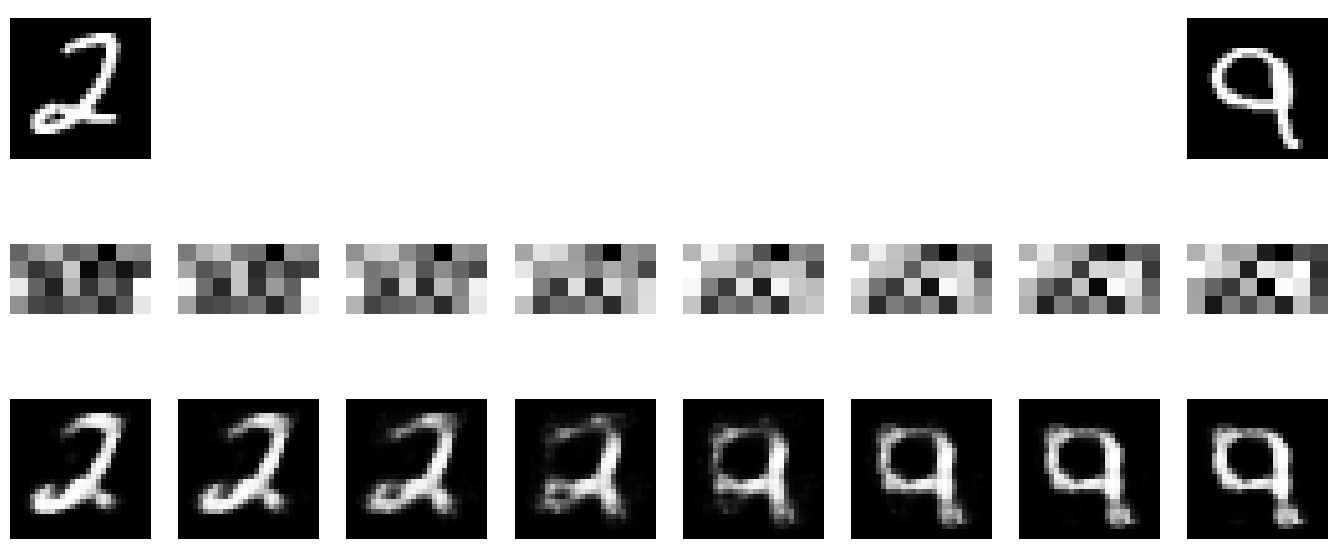

In [22]:
with torch.no_grad():
  model.eval()
  enc = model.encode(feature)

  code1, code2 = enc[0] , enc[3]
  codes = [(1-i)*code1 + i*code2 for i in np.linspace (0, 1, 8)]
  enc = torch.stack(codes)

  dcd = model.decode(enc)

fig, ax = plt.subplots(3,8,figsize=(17,7))

ax[0,0].imshow(feature[0].view(28,28).cpu(), cmap='gray')
ax[0,7].imshow(feature[3].view(28,28).cpu(), cmap='gray')

for i in range(8):
  ax[0,i].axis('off')
  ax[1,i].imshow(enc[i].view(4,8).cpu(), cmap='gray')
  ax[1,i].axis('off')
  ax[2,i].imshow(dcd[i].view(28,28).cpu(), cmap='gray')
  ax[2,i].axis('off')